In [7]:
import requests
import json
import rasterio as rio
import rioxarray as rxr
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import earthpy.plot as ep
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from pyproj import Transformer
from owslib.wms import WebMapService
import plotly.graph_objects as go

In [8]:
street='A. Verbouwelaan'
number='15'
post='8670'

In [9]:
polygone=[]

In [10]:
def house_info(street, number, post):
    a=requests.get('https://api.basisregisters.dev-vlaanderen.be/v1/adressen?'+'straatnaam='+street+'&huisnummer='+number+'&postcode='+post+'&limit=1')
    b=a.json()
    id1= b['adressen'][0]['identificator']['objectId']
    print('Address found: Id1 is',id1)
    c=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouweenheden?adresObjectId='+id1)
    d=c.json()
    id2= d['gebouweenheden'][0]['identificator']['objectId']
    print('Building units found: Id2 is',id2)
    e=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouweenheden/'+id2)
    f=e.json()
    id3= f['gebouw']['objectId']
    print('Building found: Id3 is',id3)
    g=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouwen/'+id3)
    h=g.json()
    poly=h['geometriePolygoon']['polygon']['coordinates'][0]
    polygone.append(poly)

In [11]:
house_info(street, number, post)

Address found: Id1 is 20074984
Building units found: Id2 is 20074995
Building found: Id3 is 16145178


In [12]:
all_x=[]
all_y=[]

In [13]:
for p in polygone:
    for i in p:
        first_item=i[0]
        all_x.append(first_item)
        second_item=i[1]
        all_y.append(second_item)

In [14]:
bounds_coord=min(all_x), min(all_y), max(all_x), max(all_y)

In [15]:
bounds_coord

(28128.95103101432, 201356.1280137822, 28178.24491904676, 201404.19233381748)

In [17]:
transformer = Transformer.from_crs(31370,4326)

In [18]:
b, a = transformer.transform(bounds_coord[0], bounds_coord[1])

In [19]:
d, c = transformer.transform(bounds_coord[2], bounds_coord[3])

In [20]:
a,b,c,d

(2.6283818292186503, 51.10944739754623, 2.629069438865969, 51.10988969618737)

In [21]:
wms = WebMapService('https://geoservices.informatievlaanderen.be/raadpleegdiensten/DHMV/wms?service=WMS&request=getcapabilities')

In [23]:
imgdms = wms.getmap(layers=['DHMVII_DSM_1m'], srs='EPSG:4258', bbox=(a, b, c, d), size=(300, 250), format='image/tiff',transparent=True)
out = open('DSM_selected.tif', 'wb')
out.write(imgdms.read())
out.close()

In [24]:
img_dms_raster= rxr.open_rasterio('DSM_selected.tif')


In [25]:
imgdmt = wms.getmap(layers=['DHMVII_DTM_1m'], srs='EPSG:4258', bbox=(a, b, c, d), size=(300, 250), format='image/tiff',transparent=True)
out = open('DTM_selected.tif', 'wb')
out.write(imgdmt.read())
out.close()

In [26]:
img_dmt_raster= rxr.open_rasterio('DTM_selected.tif')

In [27]:
chm_all=img_dms_raster-img_dmt_raster

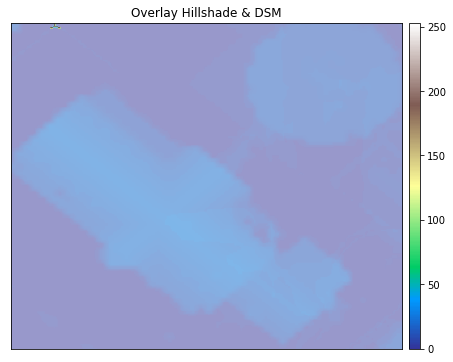

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    chm_all[1], ax=ax, cmap="terrain", title="Overlay Hillshade & DSM",
)
ax.imshow(chm_all[1], cmap="Greys", alpha=0.5)
plt.show()

In [41]:
ztwo = chm_all[1]
sh_0, sh_1 = ztwo.shape
x, y = np.linspace(0, 1, sh_0), np.linspace(0, 1, sh_1)
fig = go.Figure(data=[go.Surface(z=ztwo, x=x, y=y)])
fig.update_layout(title='House', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [33]:
zthree = img_dms_raster[1]
sh_0, sh_1 = zthree.shape
x, y = np.linspace(0, 1, sh_0), np.linspace(0, 1, sh_1)
fig = go.Figure(data=[go.Surface(z=zthree, x=x, y=y)])
fig.update_layout(title='House', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [31]:
img_dms_raster.close()
img_dmt_raster.close()